# iCAT import
---

#### Overview
The purpose of this notebook is to guide and facilitate in the creation of `render-ws` stacks. These stacks are made up of metadata regarding a collection of image tiles such as the geometric bounds, number of tiles and sections, resolution, etc. Each image tile in a stack has its own respective metadata as well, called a [tile specification](https://render-python.readthedocs.io/en/latest/guide/index.html#making-a-new-stack). Using [`pandas`](https://pandas.pydata.org/) and the [`icatapi`](https://github.com/lanery/iCAT-workflow/tree/master/icatapi), this notebook creates these tile specifications from image metadata, gathers them into stacks, and uploads the stacks to a local `render-ws` server.


#### Naming conventions
Within the context of the iCAT workflow, a collection of images from a single data source (e.g. individual fluorescence channel) is referred to as a "tileset". The collection of multiple data sources across an individual section is referred to as a "layer", while a "stack" is the collection of the same individual data source across multiple sections. A "project" is then a collection of multiple stacks.

-            | 1 section | > 1 section
------------ | --------- | -----------
\> 1 channel | layer     | project (or stacks)
1 channel    | tileset   | stack


#### Packages

In [22]:
from pathlib import Path
import re

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import TiffFile

import renderapi
import icatapi

#### Settings

In [23]:
# Indirectly enable autocomplete
%config Completer.use_jedi = False

# pandas display options
pd.set_option('display.max_colwidth', 20)

## 1) Set up environment
---

#### Connect to `render-ws`

In [24]:
from scripted_render_pipeline import basic_auth
import requests

# create an authorized session
auth = basic_auth.load_auth()
sesh = requests.Session()
sesh.auth = auth

In [25]:
# `render-ws` parameters
owner = 'skaracoban'
project = '20240219_PD05_final_test'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240219_PD05_final_test',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Set project directory

In [26]:
# Directory where raw data is stored
dir_project = Path("/long_term_storage/skaracoban/data/test_data/20240219_PD05_final_test")

# Stack directory
print(dir_project, ':\n'+'.'*len(dir_project.as_posix()))
!ls -l $dir_project | head -n 6

/long_term_storage/skaracoban/data/test_data/20240219_PD05_final_test :
.....................................................................
total 0
drwxrwxr-x 4 skaracoban skaracoban 50 Feb 20 15:26 S001


#### Link sections to z values

In [27]:
# Create section mapping
dir_sections = [dir_ for dir_ in dir_project.glob('[!_]*') if dir_.is_dir()]
d_sections = {dir_section.name: i for i, dir_section in enumerate(dir_sections)}
d_sections

{'S001': 0}

## 2) Create mipmaps
---

#### Raw data organization scheme
```
┌ {project}
└───┬ {sectionId}
    ├───┬ CLEM-grid
    │   └──── tile-{col}x{row}.tif
    └───┬ EM-grid
        ├──── tile-00002x00002.tif
        ├──── tile-00002x00003.tif
        ├──── ...
        └──── tile-{col}x{row}.tif
```

#### Mipmap output scheme
```
┌ {project}
└───┬ _mipmaps
    └───┬ {stack}
        └───┬ {sectionId}
            ├───┬ 00002x00002
            │   ├──── mm_00.tif
            │   ├──── mm_01.tif
            │   ├──── ...
            │   └──── mm_{zoom}.tif
            ├──── 00002x00003
            ├──── ...
            └──── {col}x{row}
```

In [28]:
from bs4 import BeautifulSoup as Soup
from icatapi.importo import create_mipmaps

In [29]:
# Assume subdirectories of project directory are different stacks (durr)
from curses import meta


dir_stacks = [dir_ for dir_ in dir_project.iterdir() if dir_.is_dir()]

# Loop through section directories
for z, dir_section in tqdm(enumerate(dir_sections),
                           total=len(dir_sections)):

    # Set sectionId
    sectionId = dir_section.name

    # CLEM-grid
    # ---------
    for fp in tqdm(list(dir_section.glob('CLEM-grid/*-*x*.tif')),
                   leave=False):
        # Read tiff
        tif = TiffFile(fp)
        # Extract metadata into dict as {'channel 1': metadata,
        #                                'channel 2': metadata, ...}
        metadata = tif.pages[0].description
        metadata = "\n".join(metadata.split("\n")[7:])
        
        d_metadata = {md.attrs['name']: md for md in Soup(metadata, 'lxml').find_all('image')}
        # Infer col, row
        col, row = [int(i) for i in re.findall(r'\d+', fp.stem)][-2:]

        # Loop through tiff pages
        for page in tif.pages:

            # Infer stack
            channel = page.tags['PageName'].value
            if channel == 'Secondary electrons':
                stack = 'EM_lomag'
                invert = True
            else:  # set stack name based on the excitation wavelength for FM channels
                wavelength = d_metadata[channel].channel.attrs['excitationwavelength']
                stack = f"exc_{wavelength}nm"
                invert = False

            # Create mipmaps
            image = page.asarray()
            dir_out = dir_project / '_mipmaps' / stack / sectionId / f"{col:05d}x{row:05d}"
            dir_out.mkdir(parents=True, exist_ok=True)
            _metadata = d_metadata[channel].encode(encoding='utf-8')
            create_mipmaps(image=image, dir_out=dir_out, invert=invert,
                           metadata=_metadata)

    # EM-grid
    # -------
    for fp in tqdm(list(dir_section.glob('EM-grid/*-*x*.tif')),
                   leave=False):
        # Read tiff
        tif = TiffFile(fp)
        # Extract metadata into dict as {'channel 1': metadata,
        #                                'channel 2': metadata, ...}
        metadata = tif.pages[0].description
        metadata = "\n".join(metadata.split("\n")[7:])
        # Infer col, row
        col, row = [int(i) for i in re.findall(r'\d+', fp.stem)][-2:]

        # Infer stack
        channel = tif.pages[0].tags['PageName'].value
        if channel == 'Secondary electrons':
            stack = 'EM_himag'
        else:
            raise ValueError(f"Channel {channel} is not electron microscopy data.")

        # Create mipmaps
        image = tif.asarray()
        dir_out = dir_project / '_mipmaps' / stack / sectionId / f"{col:05d}x{row:05d}"
        dir_out.mkdir(parents=True, exist_ok=True)
        create_mipmaps(image=image, dir_out=dir_out, invert=True,
                       metadata=metadata)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_1247013/4174216039.py:25: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  d_metadata = {md.attrs['name']: md for md in Soup(metadata, 'lxml').find_all('image')}


  0%|          | 0/64 [00:00<?, ?it/s]

<tifffile.TiffFile 'tile-00006x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00000.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00006x00003.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00001.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00006x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00002.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00006x00004.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')
<tifffile.TiffFile 'tile-00000x00003.tif'> OME series raised ParseError('not well-formed (invalid token): line 1, column 6')


## 3) Create tile specifications
---

#### [`TileSpec`](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) parameters

| Field        | Type           | Default | Description
| -----        | ----           | ------- | -----------
| tileId       | str            | None    | Unique string specifying a tile's identity
| z            | float          | None    | z values this tile exists within
| width        | int            | None    | Width in pixels of the raw tile
| height       | int            | None    | Height in pixels of the raw tile
| imagePyramid | `ImagePyramid` | None    | `ImagePyramid` for this tile
| minint       | int            | 0       | Pixel intensity value to display as black
| maxint       | int            | 65535   | Pixel intensity value to display as white
| layout       | `Layout`       | None    | a `Layout` object for this tile
| tforms       | list           | [ ]     | Transform objects


#### [`Layout`](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) parameters

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |


#### Building tile specifications
Will build tile specifications from base level mipmaps (which contain the metadata).

In [30]:
# Collect tile specifications
tile_dicts = []

# Subdirectories of _mipmpap directory are the different stacks
dir_stacks = [dir_ for dir_ in (dir_project/'_mipmaps').iterdir() if dir_.is_dir()]
# Loop through stacks
for dir_stack in tqdm(dir_stacks):

    # Set stack name
    stack = dir_stack.name

    # Loop through sections
    dir_sections = [dir_ for dir_ in dir_stack.iterdir() if dir_.is_dir()]
    for dir_section in tqdm(dir_sections):

        # Set sectionId and z value
        sectionId = dir_section.name
        z = d_sections[sectionId]

        # Loop through mipmap directories within each section
        for dir_mipmap in dir_section.glob('*x*'):

            # Set base-level tiff
            fp = dir_mipmap / '0.tif'

            # Create tile dict
            d_tile = {}
            d_tile['stack'] = stack
            d_tile['z'] = z
            d_tile['sectionId'] = sectionId
            d_tile = icatapi.importo.create_tile_dict(fp, d_tile=d_tile)
            # Add to collection
            tile_dicts.append(d_tile)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/skaracoban/render_code/iCAT-workflow/icatapi/importo.py:38: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = Soup(metadata, 'lxml')


#### Create stack DataFrames

In [31]:
# Create DataFrame from list of tile specifications
df_stacks = pd.DataFrame(tile_dicts)
# Infer stacks and z values
stacks = df_stacks['stack'].unique().tolist()
z_values = df_stacks['z'].unique().tolist()


# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3))

/tmp/ipykernel_1247013/2855354919.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(3))


stack  z sectionId  imageRow  imageCol      stageX  \
stack                                                                  
EM_himag  42   EM_himag  0      S001         7         1  615.275000   
          52   EM_himag  0      S001         1         3  635.920000   
          38   EM_himag  0      S001         3         1  615.223000   
EM_lomag  15   EM_lomag  0      S001         0         2  918.992000   
          10   EM_lomag  0      S001         1         0  561.515000   
          11   EM_lomag  0      S001         2         0  561.553000   
exc_405nm 4   exc_405nm  0      S001         1         1  741.007315   
          0   exc_405nm  0      S001         0         0  561.616954   
          3   exc_405nm  0      S001         0         1  740.343013   

                   stageY   pixelsize             acqTime  \
stack                                                       
EM_himag  42 -2642.004000    2.929688 2024-02-19 15:37:27   
          52 -2578.932000    2.929688 2024-02-19 15:06:05   
          38 -2599.957000    2.929688 2024-02-19 15:17:22   
EM_lomag  15 -2518.999000   36.621094 2024-02-19 14:36:22   
          10 -2700.298000   36.621094 2024-02-19 14:42:09   
          11 -2881.638000   36.621094 2024-02-19 14:44:04   
exc_405nm 4  -2700.187578  108.680692 2024-02-19 14:40:01   
          0  -2518.860735  108.669816 2024-02-19 14:32:19   
          3  -2518.755465  108.680469 2024-02-19 14:34:14   

                     imagePyramid               tileId  width  height  minint  \
stack                                                                           
EM_himag  42  [0, 1, 2, 3, 4, ...  EM_himag-S001-00...   4096    4096       0   
          52  [0, 1, 2, 3, 4, ...  EM_himag-S001-00...   4096    4096       0   
          38  [0, 1, 2, 3, 4, ...  EM_himag-S001-00...   4096    4096       0   
EM_lomag  15  [0, 1, 2, 3, 4, ...  EM_lomag-S001-00...   4096    4096       0   
          10  [0, 1, 2, 3, 4, ...  EM_lomag-S001-00...   4096    4096       0   
          11  [0, 1, 2, 3, 4, ...  EM_lomag-S001-00...   4096    4096       0   
exc_405nm 4   [0, 1, 2, 3, 4, ...  exc_405nm-S001-0...   2048    2048       0   
          0   [0, 1, 2, 3, 4, ...  exc_405nm-S001-0...   2048    2048       0   
          3   [0, 1, 2, 3, 4, ...  exc_405nm-S001-0...   2048    2048       0   

              maxint tforms  
stack                        
EM_himag  42   65535     []  
          52   65535     []  
          38   65535     []  
EM_lomag  15   65535     []  
          10   65535     []  
          11   65535     []  
exc_405nm 4    65535     []  
          0    65535     []  
          3    65535     []

#### Check tile count

In [32]:
import altair as alt

In [33]:
# Make tile count DataFrame for plotting / display purposes
source = df_stacks.loc[:, ['sectionId', 'stack', 'z']]
bars = alt.Chart(source).mark_bar().encode(
    x='count()',
    y='stack:N',
    color='stack:N',
)

text = bars.mark_text(
    align='left',
    baseline='middle'
).encode(
    text='count()'
)

alt.layer(bars, text, data=source).properties(
    width=200,
    height=150,
).facet(
    column='sectionId:N'
)

alt.FacetChart(...)

## 4) Refine tile specifications
---

### `tileId` - add alphanumeric prefix
This is because `render-ws` renders tiles alphanumerically. So we add an alphabetic prefix to tile names so that newer tiles appear on top.

In [34]:
from itertools import product

In [35]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. for n=3 [aaa, aab, aac, ..., zzx, zzy, zzz]"""
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [36]:
# Loop through tilesets
df_tilesets = []
for (stack, z), df_tileset in df_stacks.groupby(['stack', 'z']):

    # Sort by acquisition time such that top entry is last acquired
    df_tileset = df_tileset.sort_values('acqTime', ascending=False)\
                     .reset_index(drop=True).copy()

    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(df_tileset)]
    df_tileset['tileId'] = prefixes + '_' + df_tileset['tileId']
    df_tilesets.append(df_tileset)

# Concatenate tilesets
df_stacks = pd.concat(df_tilesets).reset_index(drop=True)
# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3))

/tmp/ipykernel_1247013/1968023540.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(3))


stack  z sectionId  imageRow  imageCol      stageX  \
stack                                                                  
EM_himag  10   EM_himag  0      S001         6         5  656.666000   
          14   EM_himag  0      S001         6         1  615.195000   
          61   EM_himag  0      S001         0         2  625.562000   
EM_lomag  72   EM_lomag  0      S001         0         0  561.558000   
          65   EM_lomag  0      S001         2         1  740.264000   
          68   EM_lomag  0      S001         1         1  740.259000   
exc_405nm 78  exc_405nm  0      S001         1         2  918.888391   
          74  exc_405nm  0      S001         2         1  741.012014   
          77  exc_405nm  0      S001         1         1  741.007315   

                   stageY   pixelsize             acqTime  \
stack                                                       
EM_himag  10 -2631.490000    2.929688 2024-02-19 15:31:49   
          14 -2631.490000    2.929688 2024-02-19 15:29:18   
          61 -2568.417000    2.929688 2024-02-19 14:59:49   
EM_lomag  72 -2518.992000   36.621094 2024-02-19 14:32:31   
          65 -2881.588000   36.621094 2024-02-19 14:46:00   
          68 -2700.292000   36.621094 2024-02-19 14:40:13   
exc_405nm 78 -2700.140949  108.619530 2024-02-19 14:38:05   
          74 -2881.618961  108.676258 2024-02-19 14:45:48   
          77 -2700.187578  108.680692 2024-02-19 14:40:01   

                     imagePyramid               tileId  width  height  minint  \
stack                                                                           
EM_himag  10  [0, 1, 2, 3, 4, ...  aak_EM_himag-S00...   4096    4096       0   
          14  [0, 1, 2, 3, 4, ...  aao_EM_himag-S00...   4096    4096       0   
          61  [0, 1, 2, 3, 4, ...  acj_EM_himag-S00...   4096    4096       0   
EM_lomag  72  [0, 1, 2, 3, 4, ...  aai_EM_lomag-S00...   4096    4096       0   
          65  [0, 1, 2, 3, 4, ...  aab_EM_lomag-S00...   4096    4096       0   
          68  [0, 1, 2, 3, 4, ...  aae_EM_lomag-S00...   4096    4096       0   
exc_405nm 78  [0, 1, 2, 3, 4, ...  aaf_exc_405nm-S0...   2048    2048       0   
          74  [0, 1, 2, 3, 4, ...  aab_exc_405nm-S0...   2048    2048       0   
          77  [0, 1, 2, 3, 4, ...  aae_exc_405nm-S0...   2048    2048       0   

              maxint tforms  
stack                        
EM_himag  10   65535     []  
          14   65535     []  
          61   65535     []  
EM_lomag  72   65535     []  
          65   65535     []  
          68   65535     []  
exc_405nm 78   65535     []  
          74   65535     []  
          77   65535     []

### `tforms` - set affine transformations
Place image tiles in `render` coordinate space (aka pixel space) such that top left image tile is at ~(0, 0) and its width and height are simply its width and height in pixels. Translation is derived from converting the stage position (`stageX`, `stageY`) into pixel space by dividing by the pixel size. But first, visualize the layout of each tileset.

#### Apply translations

In [37]:
from renderapi.transform import AffineModel as AffineRender

In [38]:
# Loop through tilesets
for (stack, z), df_tileset in df_stacks.groupby(['stack', 'z']):

    # Offset by stage position
    # ------------------------
    # Normalize to (0, 0) since Odemis stage position is basically random
    xs = df_tileset['stageX'] - df_tileset['stageX'].min()
    ys = df_tileset['stageY'] - df_tileset['stageY'].min()
    # Divide by pixelsize and flip y axis
    xs =  xs / (df_tileset['pixelsize']/1e3)  # um / (um/px) = px
    ys = -ys / (df_tileset['pixelsize']/1e3)  # um / (um/px) = px
    # Shift y translation up so that it's all positivo
    ys -= ys.min()

    # Create `render` affine transformations
    # --------------------------------------
    A = [[AffineRender(B0=x, B1=y)] for x, y in zip(xs, ys)]

    # Add to DataFrame
    for j, (i, tile) in enumerate(df_tileset.iterrows()):
        df_stacks.loc[i, 'tforms'] = [A[j]]

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3)).drop('tileId', axis=1)

/tmp/ipykernel_1247013/2091632144.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(3)).drop('tileId', axis=1)


stack  z sectionId  imageRow  imageCol      stageX  \
stack                                                                  
EM_himag  6    EM_himag  0      S001         7         6  667.024000   
          0    EM_himag  0      S001         7         0  604.817000   
          40   EM_himag  0      S001         2         7  677.402000   
EM_lomag  66   EM_lomag  0      S001         2         0  561.553000   
          64   EM_lomag  0      S001         2         2  919.003000   
          65   EM_lomag  0      S001         2         1  740.264000   
exc_405nm 74  exc_405nm  0      S001         2         1  741.012014   
          73  exc_405nm  0      S001         2         2  919.704801   
          81  exc_405nm  0      S001         0         0  561.616954   

                   stageY   pixelsize             acqTime  \
stack                                                       
EM_himag  6  -2642.006000    2.929688 2024-02-19 15:34:19   
          0  -2642.006000    2.929688 2024-02-19 15:38:05   
          40 -2589.443000    2.929688 2024-02-19 15:12:59   
EM_lomag  66 -2881.638000   36.621094 2024-02-19 14:44:04   
          64 -2881.591000   36.621094 2024-02-19 14:47:56   
          65 -2881.588000   36.621094 2024-02-19 14:46:00   
exc_405nm 74 -2881.618961  108.676258 2024-02-19 14:45:48   
          73 -2881.546655  108.673211 2024-02-19 14:47:44   
          81 -2518.860735  108.669816 2024-02-19 14:32:19   

                     imagePyramid  width  height  minint  maxint  \
stack                                                              
EM_himag  6   [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
          0   [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
          40  [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
EM_lomag  66  [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
          64  [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
          65  [0, 1, 2, 3, 4, ...   4096    4096       0   65535   
exc_405nm 74  [0, 1, 2, 3, 4, ...   2048    2048       0   65535   
          73  [0, 1, 2, 3, 4, ...   2048    2048       0   65535   
          81  [0, 1, 2, 3, 4, ...   2048    2048       0   65535   

                           tforms  
stack                              
EM_himag  6   [M=[[1.000000,0....  
          0   [M=[[1.000000,0....  
          40  [M=[[1.000000,0....  
EM_lomag  66  [M=[[1.000000,0....  
          64  [M=[[1.000000,0....  
          65  [M=[[1.000000,0....  
exc_405nm 74  [M=[[1.000000,0....  
          73  [M=[[1.000000,0....  
          81  [M=[[1.000000,0....

### `minint`, `maxint` - set min, max intensity levels
Sample `n` images/section to determine reasonable min/max intensity values.

In [39]:
# Set parameters
n = 10              # sample size (per section)
pcts_FM = (30, 99)  # % for intensity clipping of FM stacks
pcts_EM = (1, 99)   # % for intensity clipping of EM stacks

# Loop through stacks and sections
for (stack, z), df_tileset in tqdm(df_stacks.groupby(['stack', 'z'])):

    # Sample filepaths
    fps = df_tileset.sample(min(n, len(df_tileset)))['imagePyramid']\
                    .apply(lambda x: x[0]['imageUrl'])\
                    .tolist()

    # Collect min/max intensity values
    minints = []
    maxints = []
    # Loop through sample tiles
    for fp in fps:

        # Load tiff image
        fp_tiff = fp.split('.nl')[1]
        tiff = TiffFile(fp_tiff)
        image = tiff.asarray()

        # Get intensity percentiles
        pcts = pcts_FM if 'EM' not in stack else pcts_EM
        minint, maxint = np.percentile(image, pcts)
        minints.append(minint)
        maxints.append(maxint)

    # Set min/max intensity
    df_stacks.loc[(df_stacks['stack'] == stack) &\
                  (df_stacks['z'] == z), 'minint'] = np.mean(minints, dtype=int)
    df_stacks.loc[(df_stacks['stack'] == stack) &\
                  (df_stacks['z'] == z), 'maxint'] = np.mean(maxints, dtype=int)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.head(3)).drop('tforms', axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_1247013/945405807.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(3)).drop('tforms', axis=1)


stack  z sectionId  imageRow  imageCol      stageX  \
stack                                                                  
EM_himag  0    EM_himag  0      S001         7         0  604.817000   
          1    EM_himag  0      S001         7         1  615.275000   
          2    EM_himag  0      S001         7         2  625.552000   
EM_lomag  64   EM_lomag  0      S001         2         2  919.003000   
          65   EM_lomag  0      S001         2         1  740.264000   
          66   EM_lomag  0      S001         2         0  561.553000   
exc_405nm 73  exc_405nm  0      S001         2         2  919.704801   
          74  exc_405nm  0      S001         2         1  741.012014   
          75  exc_405nm  0      S001         2         0  562.025179   

                   stageY   pixelsize             acqTime  \
stack                                                       
EM_himag  0  -2642.006000    2.929688 2024-02-19 15:38:05   
          1  -2642.004000    2.929688 2024-02-19 15:37:27   
          2  -2642.009000    2.929688 2024-02-19 15:36:50   
EM_lomag  64 -2881.591000   36.621094 2024-02-19 14:47:56   
          65 -2881.588000   36.621094 2024-02-19 14:46:00   
          66 -2881.638000   36.621094 2024-02-19 14:44:04   
exc_405nm 73 -2881.546655  108.673211 2024-02-19 14:47:44   
          74 -2881.618961  108.676258 2024-02-19 14:45:48   
          75 -2881.496699  108.680454 2024-02-19 14:43:52   

                     imagePyramid               tileId  width  height  minint  \
stack                                                                           
EM_himag  0   [0, 1, 2, 3, 4, ...  aaa_EM_himag-S00...   4096    4096   32348   
          1   [0, 1, 2, 3, 4, ...  aab_EM_himag-S00...   4096    4096   32348   
          2   [0, 1, 2, 3, 4, ...  aac_EM_himag-S00...   4096    4096   32348   
EM_lomag  64  [0, 1, 2, 3, 4, ...  aaa_EM_lomag-S00...   4096    4096   33394   
          65  [0, 1, 2, 3, 4, ...  aab_EM_lomag-S00...   4096    4096   33394   
          66  [0, 1, 2, 3, 4, ...  aac_EM_lomag-S00...   4096    4096   33394   
exc_405nm 73  [0, 1, 2, 3, 4, ...  aaa_exc_405nm-S0...   2048    2048    3018   
          74  [0, 1, 2, 3, 4, ...  aab_exc_405nm-S0...   2048    2048    3018   
          75  [0, 1, 2, 3, 4, ...  aac_exc_405nm-S0...   2048    2048    3018   

              maxint  
stack                 
EM_himag  0    37075  
          1    37075  
          2    37075  
EM_lomag  64   37056  
          65   37056  
          66   37056  
exc_405nm 73    7574  
          74    7574  
          75    7574

## 5) Upload stacks to `render-ws`
---

In [40]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = df_stack['pixelsize'].iloc[0]
    Ry = df_stack['pixelsize'].iloc[0]
    Rz = 100

    # Create stacks
    icatapi.upload_stack_DataFrame(df=df_stack,
                                   name=stack,
                                   stackResolutionX=Rx,
                                   stackResolutionY=Ry,
                                   stackResolutionZ=Rz,
                                   render=render,
                                   session=sesh)

  0%|          | 0/3 [00:00<?, ?it/s]

Creating tile specifications for EM_himag...
Importing tile specifications to EM_himag...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240219_PD05_final_test --stack EM_himag /tmp/tmpns0xawct.json


15:32:04.869 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
15:32:05.064 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240219_PD05_final_test"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_himag",
  "tileFiles" : [
    "/tmp/tmpns0xawct.json"
  ]
}
15:32:05.400 [main]

#### Inspect stacks

  0%|          | 0/1 [00:00<?, ?it/s]

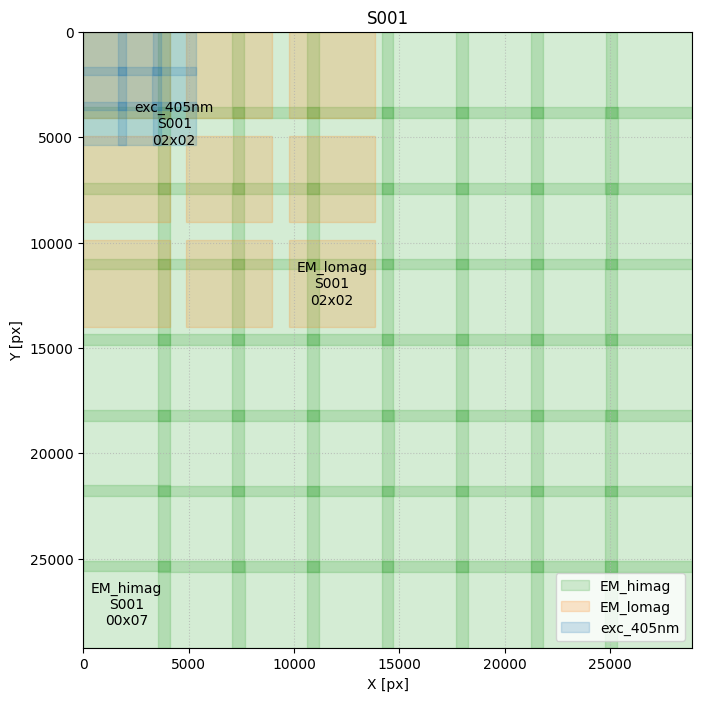

In [41]:
# Get stacks
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

# Plot tile map
stacks_2_plot = stacks
icatapi.plot_tile_map(stacks_2_plot,
                      render=render)

  0%|          | 0/3 [00:00<?, ?it/s]

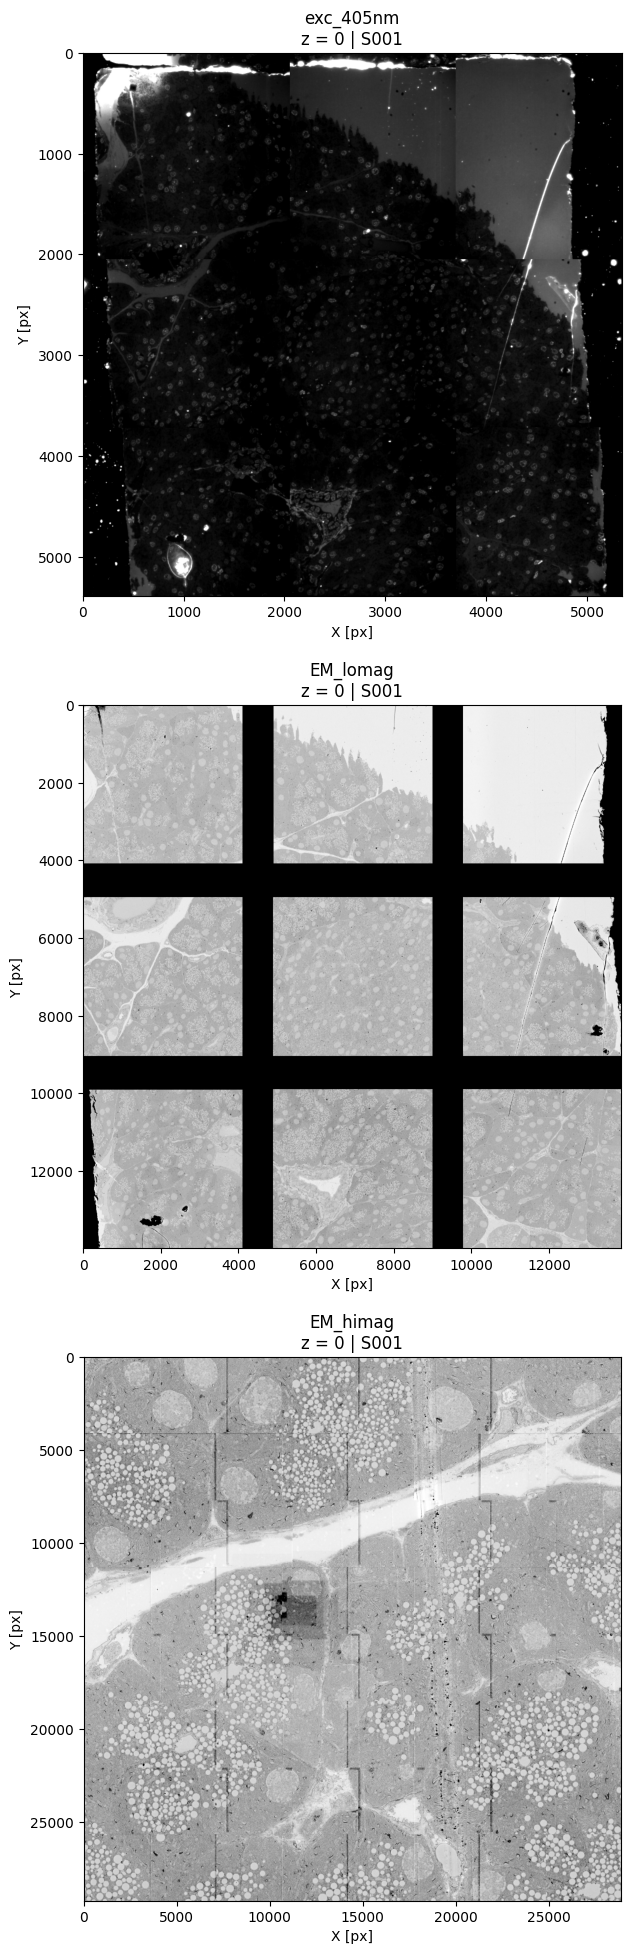

In [42]:
# Plot stack images
icatapi.plot_stacks(stacks=stacks_2_plot,
                    maxTileSpecsToRender=500,
                    render=render)